In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy 
from astropy import units as u
from astropy.convolution import Tophat2DKernel
from astropy.coordinates import SkyCoord
import os
import scipy.optimize
from scipy.stats import norm
#from utils import mkdir, get_binc, format_log_axis
import regions
from regions import CircleSkyRegion
#import format_log_axis
import warnings
warnings.filterwarnings('ignore')

In [2]:
import gammapy
from gammapy.makers import MapDatasetMaker, RingBackgroundMaker, SafeMaskMaker
from gammapy.datasets import MapDataset, MapDatasetOnOff
from gammapy.data import DataStore
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.estimators import ExcessMapEstimator

print ('Astropy version:', astropy.__version__)
print ('Gammapy version:', gammapy.__version__)
print ('Regions version:', gammapy.__version__)

Astropy version: 4.0.3
Gammapy version: 0.17
Regions version: 0.17


In [3]:
W = 10
params = {'figure.figsize': (W, W/(4/3)),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'font.size' : 16,
         'text.usetex': True,
         'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'),
          'font.family': 'lmodern',
          'legend.fontsize': 16,
          
          }

plt.rcParams.update(params)

In [4]:
run_list = "night2"
bkgmodel_version = "v07c"

In [16]:
work_dir = "/Users/jean/Documents/PhD/gammapy/GRBs/190829A/v17/new_analysis/grb_analysis/grb190829a/"

def save(fig, figname, left = 0.15, bottom = 0.15, right = 0.95, top = 0.95):
    fig.subplots_adjust(left = left, bottom = bottom, top = top, right = right)
    format_fig = ['png','pdf'] # 'eps'
    for form in format_fig:
        fig.savefig(work_dir + "plots/plots_2D/{}/jupyter_notebooks/grb190829A_{}_{}.{}"
                    .format(run_list,run_list, figname, form))
W = 10

params = {'figure.figsize': (W, W/(4/3)),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'font.size' : 16,
         'text.usetex': True,
          'font.family': "sans-serif",
          'legend.fontsize': 16,
          }
plt.rcParams.update(params)

In [17]:
runs_night1 = [152900, 152901, 152902, 152903, 152904, 152905, 152906, 152907]
runs_night2 = [152960, 152961, 152962, 152963, 152965, 152966, 152967, 152968, 152969, 152970]
runs_night3 = [153040, 153041, 153042, 153043, 153044, 153047, 153048, 153049, 153050] # 153045 (too short)

if run_list == 'night1':
    runs = runs_night1
    
elif run_list == 'night2':
    runs = runs_night2
    
elif run_list == 'night3':
    runs = runs_night3
    
elif run_list == 'all':
    runs = runs_night1 + runs_night2 +runs_night3

In [18]:
ds = DataStore.from_dir("$GAMMAPY_DATA/std_ImPACT_fullEnclosure")
observations = ds.get_observations (runs)
#print(observations)

## Target Position

In [19]:
ra = 44.544
dec = -8.958

source_pos = SkyCoord(ra, dec, frame = 'icrs', unit = 'deg')

In [20]:
energy_axis = MapAxis.from_edges ( 
    np.logspace(-0.875, 1.75, 43), unit = 'TeV', name = 'energy', interp = 'log'
                                 
                                 )

geom = WcsGeom.create( 
    skydir=source_pos,
    binsz = 0.02,
    width = (4, 4),
    frame = 'icrs',
    axes = [energy_axis],
    
                     )

geom_image = geom.to_image().to_cube([energy_axis.squash()])

#print(energy_axis)

In [21]:
%%time

maker = MapDatasetMaker( selection = ['counts', 'exposure', 'background'])

maker_safe_mask = SafeMaskMaker(methods = ['offset-max'], offset_max = 2.5 *u.deg )

reference = MapDataset.create(geom)

datasets = []

for obs in observations:
    dataset = maker.run(reference, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    datasets.append(dataset)

CPU times: user 9.96 s, sys: 2.85 s, total: 12.8 s
Wall time: 12.9 s


In [22]:
# get the geom that we use
geom = datasets[0].counts.geom
energy_axis = datasets[0].counts.geom.get_axis_by_name("energy")
geom_image = geom.to_image().to_cube([energy_axis.squash()])

# Make the exclusion mask
regions = CircleSkyRegion(center=source_pos, radius=0.3 * u.deg)
exclusion_mask = Map.from_geom(geom_image)
exclusion_mask.data = geom_image.region_mask([regions], inside=False)

In [23]:
ring_maker = RingBackgroundMaker (
    r_in = 0.5*u.deg, width = 0.3 *u.deg, exclusion_mask = exclusion_mask
)

In [24]:
%%time
# for this we need to stack all observations together.
stacked_on_off = MapDatasetOnOff.create(geom = geom_image, name = 'grb-stacked')
for dataset in datasets:
    dataset_image = dataset.to_image()
    dataset_on_off = ring_maker.run(dataset_image)
    stacked_on_off.stack(dataset_on_off)

CPU times: user 1.01 s, sys: 398 ms, total: 1.41 s
Wall time: 1.41 s


In [25]:
print (stacked_on_off)

MapDatasetOnOff
---------------

  Name                            : grb-stacked 

  Total counts                    : 31652 
  Total predicted counts          : nan
  Total background counts         : nan

  Exposure min                    : 4.21e+07 m2 s
  Exposure max                    : 1.51e+09 m2 s

  Number of total bins            : 40000 
  Number of fit bins              : 40000 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

    Total counts_off                : 82757112 
    Acceptance                      : 40000 
    Acceptance off                  : 105658066 



## Let's see what we have just done so far
### a) ON exposure Map

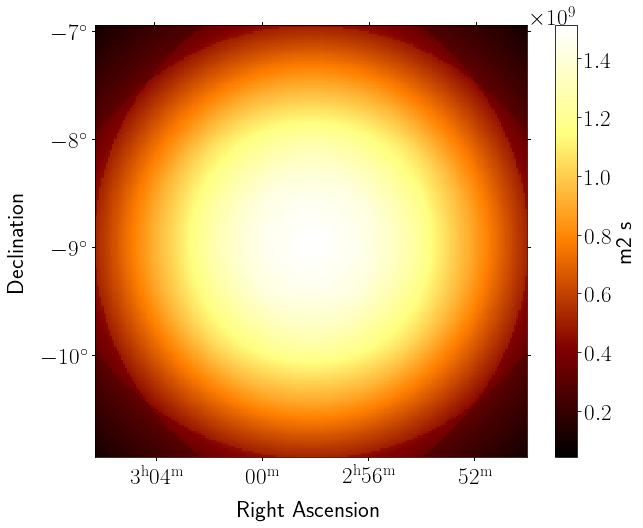

In [27]:
fig = plt.figure()
f_exp_on = stacked_on_off.exposure.sum_over_axes().plot(add_cbar = True)[0]
save(fig, '2D-On-exposure-map_low_level')

## b) Off exposure Map

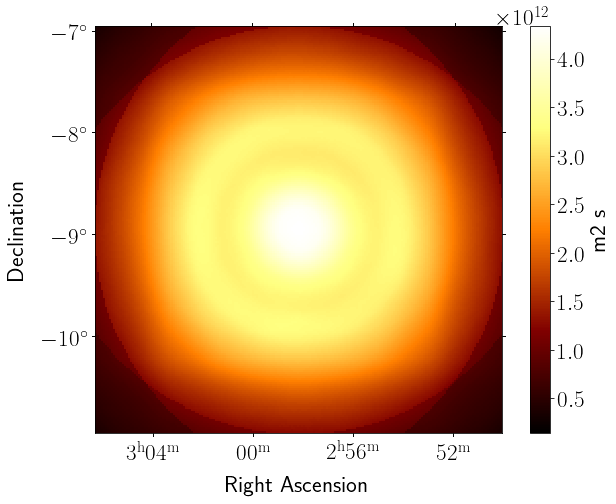

In [28]:
exp_off = stacked_on_off.exposure.sum_over_axes()*stacked_on_off.acceptance_off.sum_over_axes()
f_exp_off = exp_off.sum_over_axes().plot(add_cbar = True)[0]
save(fig, '2D-off-exposure-map_low_level')

## c. On-Counts map

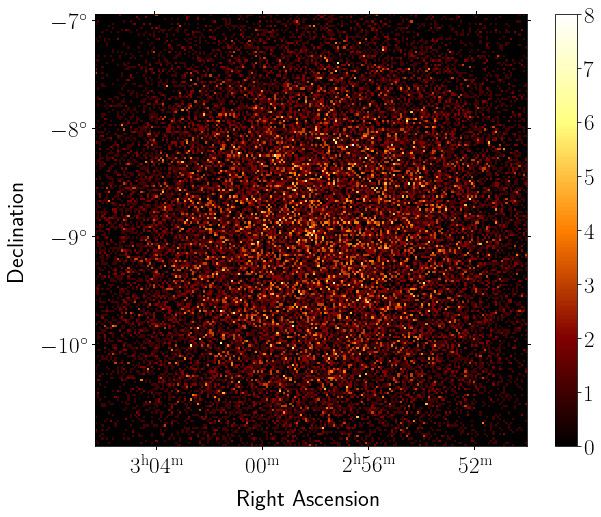

In [29]:
fig,ax,_ = stacked_on_off.counts.sum_over_axes().plot(add_cbar = True)
save(fig, '2D-On-counts_maps_low_level')

## d. Off-counts map

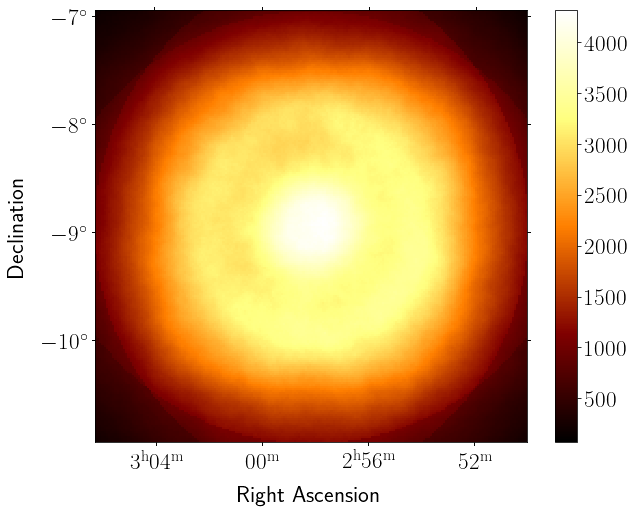

In [30]:
fig, ax,_ = stacked_on_off.counts_off.sum_over_axes().plot(add_cbar = True)
save(fig, '2D-off-counts-maps_low_level')

## Alpha Map

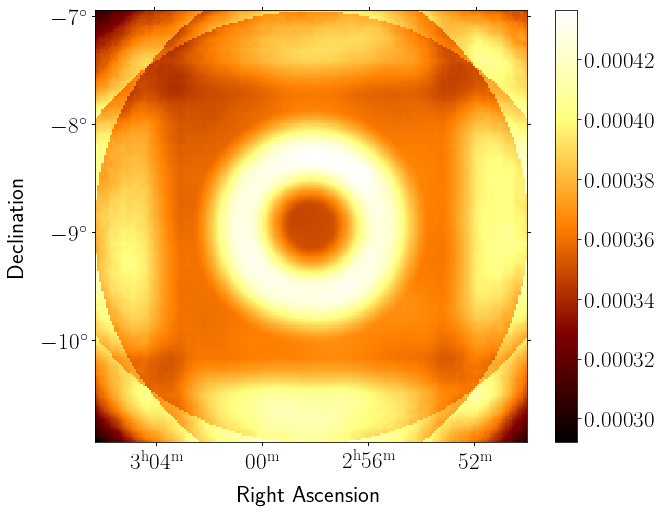

In [31]:
fig, ax,_ = stacked_on_off.alpha.sum_over_axes().plot(add_cbar = True)
save(fig, '2D-Alpha-maps_low_level')

<Figure size 720x540 with 0 Axes>

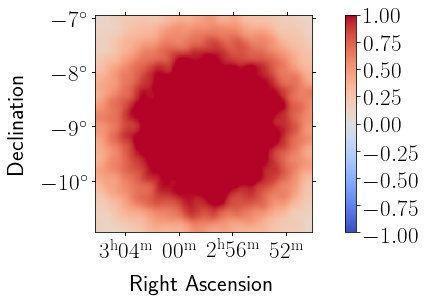

In [32]:
fig = plt.figure()
fig,ax = stacked_on_off.plot_residuals(vmin = -1, vmax=1)

# Estimating Li & Ma maps

In [33]:
%%time
# Using a convolution radius of 0.04 degrees
estimator = ExcessMapEstimator(0.05 * u.deg, )
lima_maps = estimator.run(stacked_on_off, steps="all")

CPU times: user 4min 50s, sys: 21.5 s, total: 5min 12s
Wall time: 5min 12s


## e. Cliped Excess map [clipped at zero]

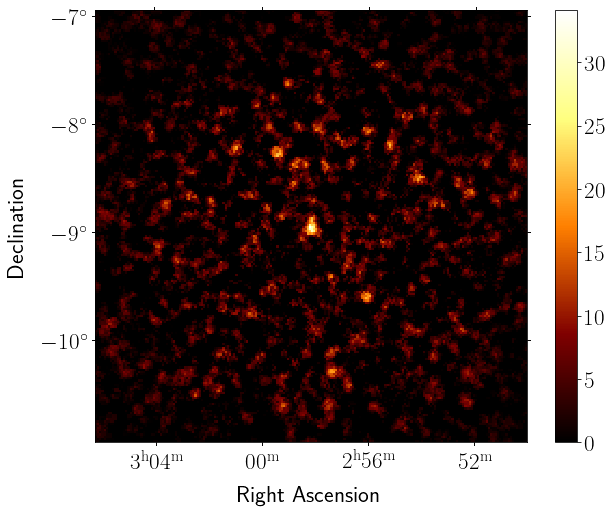

In [34]:
map_excess_clipped = lima_maps['excess'].copy()
map_excess_clipped.data = map_excess_clipped.data.clip(min = 0)
fig, ax,_ = map_excess_clipped.sum_over_axes().plot(add_cbar = True)
save(fig, '2D-excess-map_low_level')

## f. Excess map with source excluded.

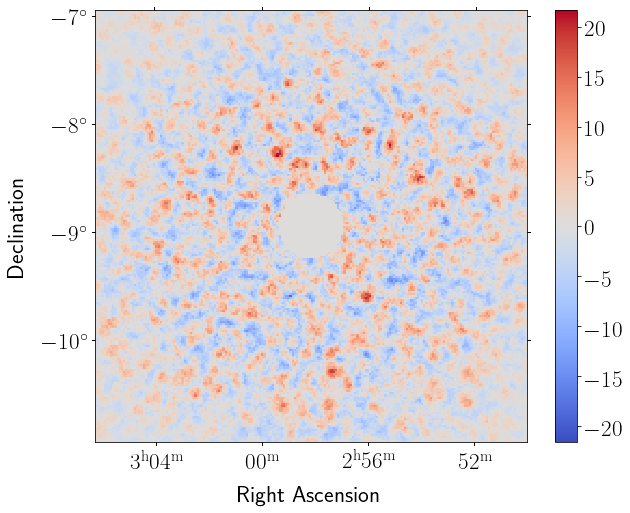

In [35]:
map_excess_excl = lima_maps['excess'].copy()
map_excess_excl.data[:] *= exclusion_mask.data[0]
maxentry = np.abs(map_excess_excl.data).max()
fig,ax,_ = map_excess_excl.sum_over_axes().plot(
    add_cbar = True, cmap='coolwarm', vmin = -maxentry, vmax=maxentry
                                               )
save(fig, '2D-excess_withexclusion_low_level')

## g. Background Map

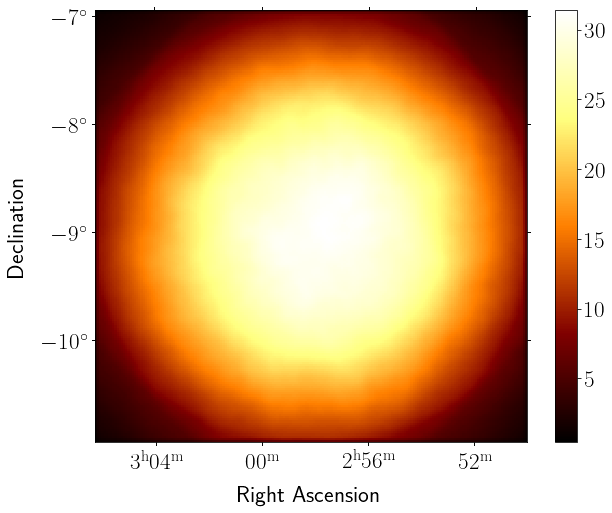

In [36]:
fig,ax,_ = lima_maps['background'].sum_over_axes().plot(add_cbar = True)
save(fig, '2D-background-map_low_level')

## h. Symmetric error Map

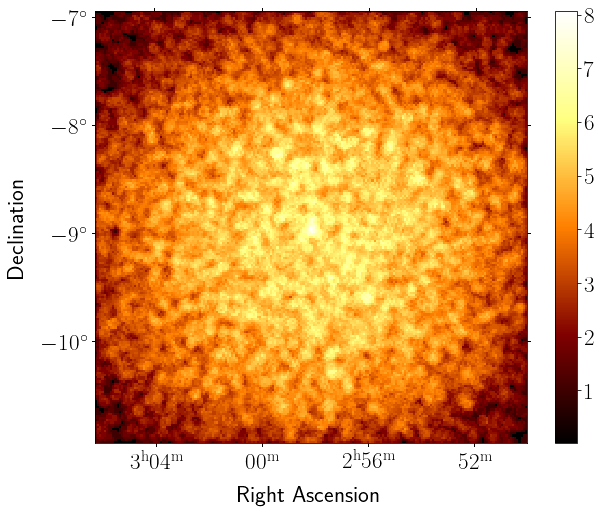

In [37]:
fig,ax,_ = lima_maps['err'].sum_over_axes().plot(add_cbar = True)
save(fig, '2D-symetric_error-map_low_level')

## i. Negative Asymmetric error Map

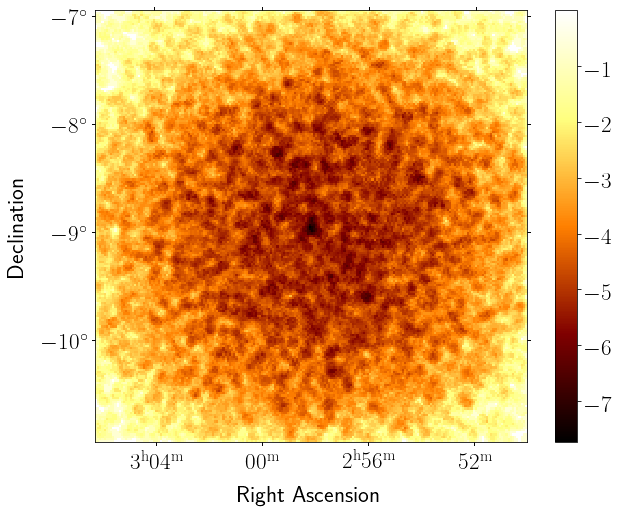

In [38]:
fig,ax,_ = lima_maps['errn'].sum_over_axes().plot(add_cbar = True)
save(fig, '2D-negative_asymmetric_error-map_low_level')

## j. Positive Asymmetric error Map

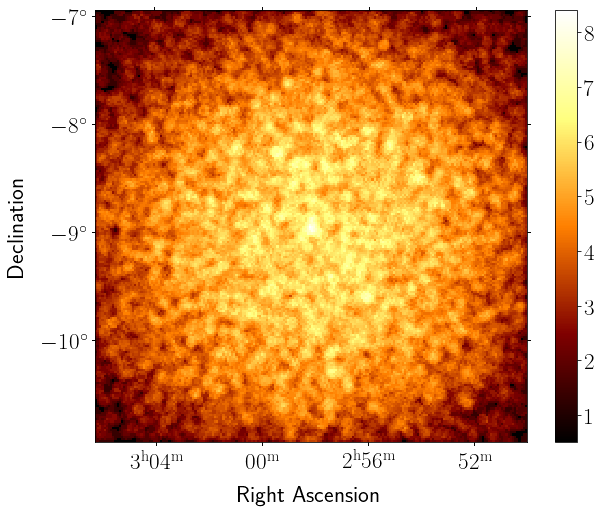

In [39]:
fig,ax,_ = lima_maps['errp'].sum_over_axes().plot(add_cbar = True)
save(fig, '2D-positive_asymmetric_error-map_low_level')

## k. Upper limit Map

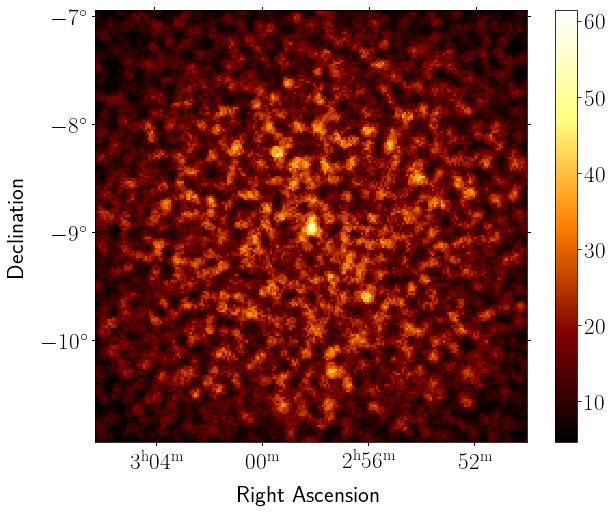

In [40]:
fig,ax,_ = lima_maps['ul'].sum_over_axes().plot(add_cbar = True)
save(fig, '2D-upperlimit-map_low_level')

## l. Test Statistic Map

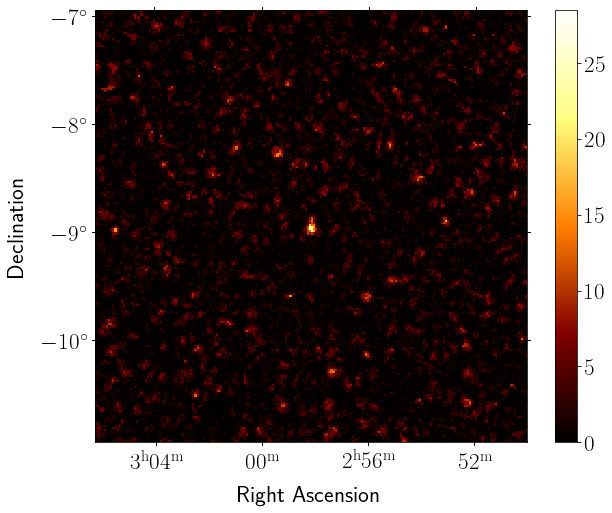

In [41]:
fig,ax,_ = lima_maps['ts'].sum_over_axes().plot(add_cbar = True)
save(fig, '2D-TS-map_low_level')

## m. Significance map

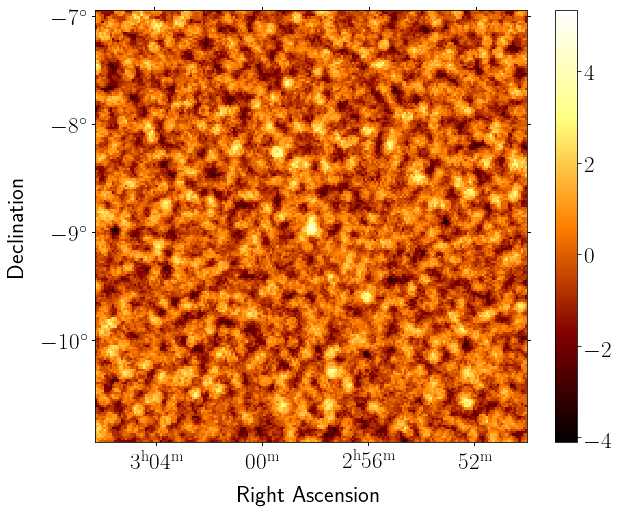

In [42]:
map_sign_clipped = lima_maps['significance'].copy()
#map_sign_clipped.data = map_sign_clipped.data.clip(min=0) # do not clip
fig,ax,_ = map_sign_clipped.sum_over_axes().plot(add_cbar = True)
save(fig, '2D-significance-map_low_level')

## n. Significance map with source excluded

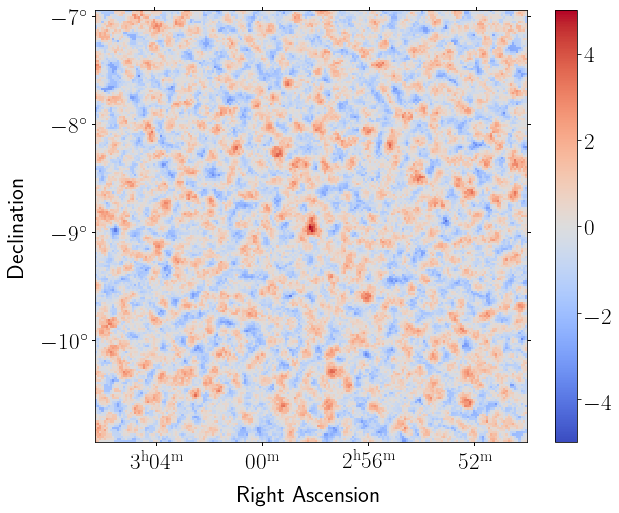

In [43]:
map_sign_excl = lima_maps['significance'].copy()

# map_sign_excl.data *= mask.data[0]

fig,ax,cb = map_sign_excl.sum_over_axes().plot(
    add_cbar = True, cmap = 'coolwarm', vmin=-5, vmax=5, 
                                              )
save(fig, '2D-significance-map_with_exclusion_low_level')

## o. Significance distribution 
### (include only pixels within 2.25 deg radius)

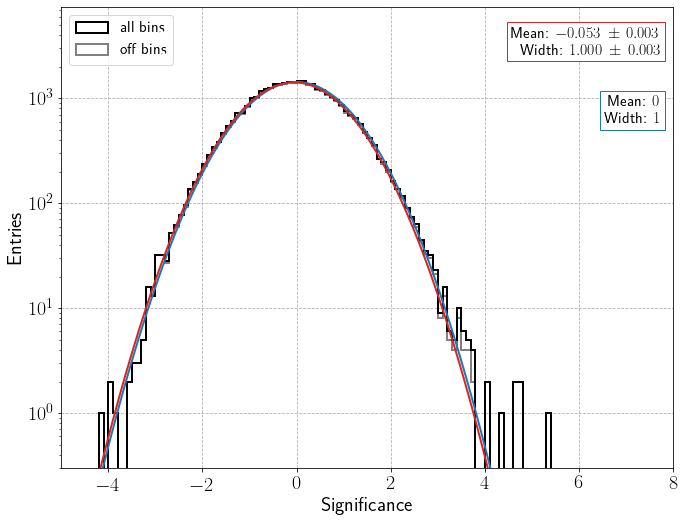

In [44]:
sdbins = np.linspace (-5, 8,131)
def get_binc(bins):
    bin_center = (bins[:-1] + bins[1:]) / 2
    return bin_center
reg_inner = CircleSkyRegion(source_pos, 2.25 * u.deg)
inner = geom.region_mask([reg_inner], inside=True)[0]

sign_inner = lima_maps['significance'].sum_over_axes().data[inner]

sign_excl = map_sign_excl.sum_over_axes().data.copy()
sign_excl[~exclusion_mask.data[0].astype(bool)] = -999.
sign_excl_inner = sign_excl[inner]
sign_inner[np.isnan(sign_excl_inner)] = -999.
sign_excl_inner[np.isnan(sign_excl_inner)] = -999.

fig = plt.figure(figsize=(10, 8))
ax = fig.add_axes([0.12, 0.12, 0.85, 0.8])
ax.grid(ls='--')
ax.set_yscale('log')
ax.set_xlabel('Significance', fontsize =20)
ax.set_ylabel('Entries', fontsize =20)
h = ax.hist(sign_inner, bins=sdbins, histtype='step', color='k', lw=2, zorder=5, label = 'all bins')[0]
h = ax.hist(sign_excl_inner, bins=sdbins, histtype='step', color='gray', lw=2, zorder=3, label = 'off bins')[0]

gaus = lambda x,amp,mean,sigma:amp*np.exp(-(x-mean)**2/2/sigma**2)
xv = np.linspace(sdbins[0], sdbins[-1], 1000)
res = scipy.optimize.curve_fit(gaus, get_binc(sdbins), h, p0=[h.max(), 0., 1.])
pars = res[0]
errs = np.sqrt(np.diag(res[1]))
ax.plot(xv, gaus(xv, pars[0], pars[1], pars[2]), color='tab:red', lw=2, zorder=7)

ax.text(0.98, 0.96, 'Mean: ${:.3f}\,\pm\,{:.3f}$\nWidth: ${:.3f}\,\pm\,{:.3f}$'.format(pars[1],errs[1], pars[2], errs[2]),
        ha='right', va='top', bbox=dict(edgecolor='tab:red', facecolor='white'), transform=ax.transAxes, fontsize=16)

ax.plot(xv, gaus(xv, h.max(), 0, 1), color='tab:blue', lw=2, zorder=6)

ax.text(0.98, 0.81, 'Mean: $0$\nWidth: $1$', ha='right', va='top',fontsize=16,
        bbox=dict(edgecolor='tab:blue', facecolor='white'), transform=ax.transAxes)

ax.set_xlim(sdbins[0], sdbins[-1])
ax.set_ylim(bottom=0.3)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc = 'upper left',fontsize=16)
# format_log_axis(ax.yaxis)
save(fig, '1D_significance_distribution_low_level')

## p. Theta^2 Distribution plot.

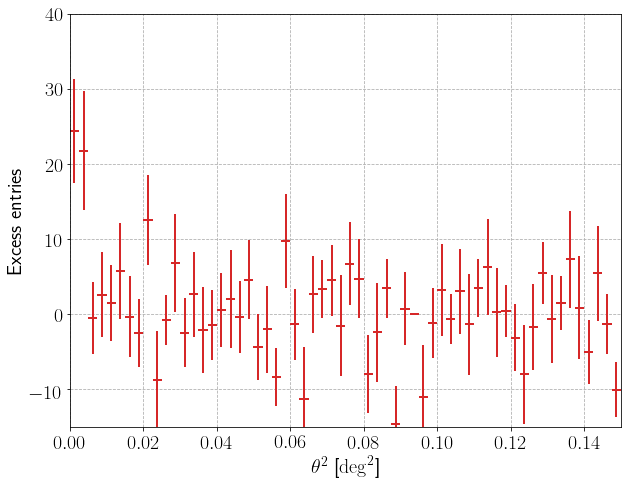

In [45]:
# Theta^2 plot
tsbins = np.linspace(0, 0.3, 121)
excess_noconv = stacked_on_off.excess
excess_noconv_err = np.sqrt(stacked_on_off.counts.sum_over_axes().data +\
                            stacked_on_off.alpha.data**2 * stacked_on_off.counts_off.sum_over_axes().data)
thsq = stacked_on_off.counts.geom.get_coord().skycoord.separation(source_pos).value**2
thsq_excess = np.histogram(thsq, bins=tsbins, weights=excess_noconv)[0]
thsq_excess_err = np.sqrt(np.histogram(thsq, bins=tsbins, weights=excess_noconv_err**2)[0])

tsbinc = get_binc(tsbins)
xerr = [tsbinc - tsbins[:-1], tsbins[1:] - tsbinc]

# create figure
fig = plt.figure(figsize=(9, 7))
ax = fig.add_axes([0.12, 0.15, 0.85, 0.82])
ax.grid(ls='--')
ax.set_xlabel(r'$\theta^2$ [$\mathrm{deg}^2$]', fontsize = 20)
ax.set_ylabel('Excess entries', fontsize = 20)

# plot distributions
pexc = ax.errorbar(tsbinc, thsq_excess, xerr=xerr, yerr=thsq_excess_err, linestyle='None',
                   ecolor='tab:red', capsize=0, elinewidth=2)

# set axis limits
ax.set_xlim(tsbins[0], 0.15)
ax.set_ylim(-15, 40)
ax.tick_params(axis='both', which='major', labelsize=20)
save(fig, '1D-thetasquare_distribution_low_level')

## r) Total significance 
### Distribution Histogram in the whole FoV.

Fit results: mu = -0.04, std = 1.00


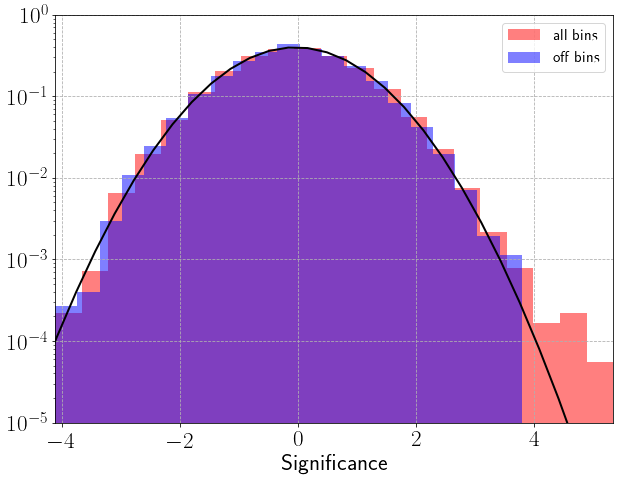

In [46]:
# create a 2D mask for the images
significance_map_off = lima_maps['significance'] * exclusion_mask
significance_all = lima_maps['significance'].data[np.isfinite(lima_maps['significance'].data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)
]

plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=21,
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=21,
)

# Now, fit the off distribution with a Gaussian
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
plt.legend()
plt.xlabel("Significance")
plt.yscale("log")
plt.ylim(1e-5, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin, xmax)
plt.grid(ls='--')
save(fig, 'Total_significance_distribution_low_level')
print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")